Night Sky Object Identification and Mapping

In [ ]:
from astropy.coordinates import SkyCoord
import astropy.units as u
import numpy as np
import random
import cv2
import math
from typing import List, Tuple
import matplotlib.pyplot as plt
import scipy.ndimage as ndi
from scipy.stats import rv_discrete
from skimage.filters import gaussian
from scipy.ndimage import convolve

#TO DO LIST


*   Fix noise generation DONE
*   Made star blur scaleas a sqrt DONE
*   Fix higher magnification resulting in overly blurry images and small number of stars DONE WITH PREVIOUS
*   Work on object generation DONE
*   Pull the coordinates out of the data so we add them manually DONE
*   Create a way to tell the code tat you want n images of a certain object and have the code correctly make images. DONE
*   Automatic signal to noise ratio. DONE
*   Implement a way to speed up the code & research neural nets before creating the dataset



#Calculating images

##Star code

In [ ]:
stars_per_magnitude = {
    2.0: 48,
    3.0: 171,
    4.0: 513,
    5.0: 1602,
    6.0: 4800,
    7.0: 14000,
    8.0: 42000,
    9.0: 121000,
    10.0: 340000,
    11.0: 725346,
    12.0: 1374412,
    13.0: 2378009,
    14.0: 3844017,
    15.0: 5894386,
    16.0: 8665135,
    17.0: 12306357,
    18.0: 16982212,
    19.0: 22870933,
    20.0: 30164822, #used regression to find those above 20
    21.0: 3.997534295069156e7,
    22.0: 5.192083183249308e7,
    23.0: 6.6644844115279734e7,
    24.0: 8.462953308674893e7,
    25.0: 1.0641478627977826e8,
    26.0: 1.3260229977121532e8,
    27.0: 1.6385975616052195e8,
    28.0: 2.009251045589161e8,
}

def count_stars_in_range(start_magnitude: float, end_magnitude: float):
    total_stars = 0
    for magnitude in range(int(start_magnitude), int(end_magnitude) + 1):
        total_stars += stars_per_magnitude.get(magnitude, 0)
    return total_stars

def generate_stars(min_magnitude, percent_of_sky):
    # Number of stars to generate
    num_stars = int(count_stars_in_range(0, min_magnitude) * percent_of_sky)

    # List to hold the ranges of magnitudes
    magnitude_ranges = [(i, i+1, count_stars_in_range(i, i+1)*percent_of_sky) for i in range(0, min_magnitude)]

    stars = []
    for _ in range(num_stars):
        # Generate a random number to determine the magnitude bracket
        rand_number = random.random() * num_stars

        # Determine the bracket the random number falls into
        total = 0
        for mag_range in magnitude_ranges:
            total += mag_range[2]
            if rand_number <= total:
                break

        # Assign a magnitude to the star within the selected range
        magnitude = random.uniform(mag_range[0], mag_range[1])

        # Assign random coordinates to the star
        coord_x = random.random() * 100  # Percentage from left to right
        coord_y = random.random() * 100  # Percentage from bottom to top

        # Append the star (represented as a dictionary) to the list
        stars.append({"magnitude": magnitude, "coordinates": (coord_x, coord_y)})

    return stars

def add_diffraction_spikes(image, center, brightness, magnitude, magnitude_threshold, num_spikes, glow_radius):
    # Only add spikes to stars brighter than a certain threshold
    if magnitude > magnitude_threshold:
        return image

    # Define the base spike length
    base_spike_length = 2 * glow_radius

    # Calculate a factor to increase the spike length based on the star's magnitude
    magnitude_factor = 1.2 ** (magnitude_threshold - magnitude)

    # Calculate the final spike length including the magnitude factor
    final_spike_length = int(base_spike_length * magnitude_factor)

    # Add the spikes
    for i in range(num_spikes):
        # Calculate the direction of the spike
        angle = 2 * math.pi * i / num_spikes
        direction = (math.cos(angle), math.sin(angle))

        # Draw the spike on the image pixel by pixel
        for j in range(final_spike_length):
            position = (
                int(center[0] + direction[0] * j),
                int(center[1] + direction[1] * j)
            )
            # Fade brightness in the latter half of the spike
            if j >= final_spike_length / 2:
                pixel_brightness = brightness * (1 - 2 * (j - final_spike_length / 2) / final_spike_length)
            else:
                pixel_brightness = brightness

            # Check if the position is within the image boundaries before setting the pixel value
            if 0 <= position[0] < image.shape[1] and 0 <= position[1] < image.shape[0]:
                image[position[1], position[0]] = min(255, image[position[1], position[0]] + int(pixel_brightness))

    return image

def create_star_image(stars, celestial_object, celestial_object_position, image_size, exposure_time, magnitude_threshold, num_spikes):
    # Create a black image
    image = np.zeros(image_size, dtype=np.uint8)

    # Add the celestial object to the stars list with the given position
    stars = stars + [{'magnitude': celestial_object['magnitude'], 'coordinates': celestial_object_position}]

    # Calculate the maximum and minimum star magnitude
    min_magnitude = min(star['magnitude'] for star in stars)
    max_magnitude = max(star['magnitude'] for star in stars)

    # List to store the stars that need diffraction spikes
    stars_with_spikes = []

    # Map each star onto the image
    for star in stars:
        if star['magnitude'] == celestial_object['magnitude'] and star['coordinates'] == celestial_object_position:
            continue  # Skip the celestial object

        # Calculate star brightness
        if max_magnitude == min_magnitude:
            brightness = 255
        else:
            brightness = int(((max_magnitude - star['magnitude']) / (max_magnitude - min_magnitude)) * 255)

        # Calculate the position of the star in the image
        position = (int(star['coordinates'][1] / 100 * image_size[1]),
                    int(star['coordinates'][0] / 100 * image_size[0]))

        # Add a glow around the star
        glow_radius = calculate_glow_radius(star['magnitude'], max_magnitude, exposure_time)
        image = add_glow(image, position, brightness, glow_radius)

        # Set the pixel at the star's position to the star's brightness
        image[position[1], position[0]] = min(255, image[position[1], position[0]] + brightness)

        # Add star to the list of stars that need diffraction spikes if it meets the magnitude threshold
        if star['magnitude'] <= magnitude_threshold:
            stars_with_spikes.append((position, brightness, star['magnitude'], glow_radius))

    # Add diffraction spikes around the stars
    for position, brightness, magnitude, glow_radius in stars_with_spikes:
        image = add_diffraction_spikes(image, position, brightness, magnitude, magnitude_threshold, num_spikes, glow_radius)

    return image

def calculate_glow_radius(star_magnitude, max_magnitude, exposure_time):
    base_magnitude = 0  # or another value to scale the radius
    relative_magnitude = max_magnitude - star_magnitude
    # calculate base 10 logarithm of relative brightness, and scale it by a factor
    glow_radius = int(0.1 * np.log10(2.5**relative_magnitude) * np.sqrt(exposure_time))  # Using square root of exposure time
    return glow_radius


def add_glow(image, center, brightness, radius):
    # Calculate the square area to consider for the glow
    min_x = max(0, center[0] - radius)
    max_x = min(image.shape[1], center[0] + radius)
    min_y = max(0, center[1] - radius)
    max_y = min(image.shape[0], center[1] + radius)

    # Iterate over the area and add the glow
    for x in range(min_x, max_x):
        for y in range(min_y, max_y):
            # Calculate the distance to the center of the glow
            distance = np.sqrt((x - center[0])**2 + (y - center[1])**2)

            # Calculate the glow brightness
            glow_brightness = int(brightness * (1 - distance / radius))
            glow_brightness = max(0, glow_brightness)  # make sure the brightness never goes below zero

            # Add the glow to the pixel
            if (y, x) == center:
                image[y, x] = glow_brightness
            else:
                image[y, x] = min(255, image[y, x] + glow_brightness)

    return image

##Object code

In [ ]:
def distribute_brightness(image, position, magnitude, angular_size_deg, fov_deg, image_size, exposure_time, aperture_diameter):
    imageTemp = image.copy()

    # Calculate the brightness using exposure time and aperture
    C = 255 * 10 ** -0.4  # Astronomical Magnitude System constant
    brightness = C * exposure_time * aperture_diameter**2 * 10 ** (-0.4 * magnitude)

    # Convert angular size in degrees to radius in pixels
    radius_pixels = angular_size_deg / fov_deg * image_size[0] / 2

    # Define a temporary array to store the added brightness
    added_brightness = np.zeros_like(image, dtype=float)

    # Check every pixel
    for x in range(image_size[0]):
        for y in range(image_size[1]):
            dx, dy = x - position[0], y - position[1]
            distance = math.hypot(dx, dy)

            if distance > radius_pixels:
                continue  # Pixel is outside the object

            # Calculate the proportion of the pixel covered by the object
            if distance + 1 < radius_pixels:
                proportion = 1  # Pixel is completely inside the object
            else:
                # Pixel is partially inside the object.
                # We approximate the proportion using a linear model (which is a rough approximation)
                proportion = 1 - (distance + 0.5 - radius_pixels)

            # Add the brightness to the pixel
            added_brightness[y, x] += proportion * brightness / (math.pi * radius_pixels**2)

            # Set pixel brightness within object to 0 in the original image
            imageTemp[y, x] = 0

    # Normalize the brightness so that the maximum added brightness is 255
    max_added_brightness = added_brightness.max()
    if max_added_brightness > 0:
        added_brightness *= 255 / max_added_brightness

    # Add the additional brightness to the image, but don't exceed 255
    imageTemp = np.minimum(255, imageTemp + added_brightness)

    return imageTemp

def angular_size(diameter_km, sma_m):
    # Convert diameter to meters
    diameter_m = diameter_km * 1e3

    # Calculate angular size in radians
    A_rad = diameter_m / sma_m

    # Convert to degrees
    A_deg = math.degrees(A_rad)

    return A_deg

def can_image_planet(planet_properties, fov_degrees, n_images, time_per_image, is_moving_left_to_right):
    # Constants
    gravitational_constant = 6.67430e-11  # m^3 kg^-1 s^-2
    solar_mass = 1.98847e30  # kg
    AU_to_meters = 1.495978707e11  # 1 AU in meters

    # Extract the semi-major axis in AU and convert it to meters
    sma_meters = planet_properties['sma_AU'] * AU_to_meters

    # Use Kepler's Third Law to compute the orbital period (in seconds)
    orbital_period = 2 * math.pi * math.sqrt(sma_meters**3 / (gravitational_constant * solar_mass))

    # Convert the orbital period to degrees per second
    degrees_per_second = 360 / orbital_period

    # Compute the total time span of the image sequence
    total_time = n_images * time_per_image

    # Compute the total angle covered by the planet during this time
    total_angle = total_time * degrees_per_second

    # Check whether this total angle would fit within the field of view of the camera
    if total_angle > fov_degrees:
        return 0

    # Calculate the path width as a percentage of the field of view
    path_width_percent = total_angle / fov_degrees * 100

    return path_width_percent


def add_object_to_image(image, planet_properties, coordinates, fov_deg, exposure_time, aperture_diameter):
    image_size = image.shape

    # Convert from percent to pixels
    object_coordinates_pixels = (int(coordinates[0] / 100 * image_size[1]),
                                 int(coordinates[1] / 100 * image_size[0]))

    # Calculate the angular size
    angle = angular_size(planet_properties['diameter_km'], planet_properties['sma_AU']*1.496e11)

    # Add the object to the image
    image_with_object = distribute_brightness(image, object_coordinates_pixels, planet_properties['magnitude'], angle, fov_deg, image_size, exposure_time, aperture_diameter)

    return image_with_object

In [ ]:
import math

def calculate_apparent_magnitude(dBS, D, p):
    dBO = dBS - 1

    # Calculate the absolute magnitude using albedo and diameter of the planet
    H = 5*math.log10(1329/(D*math.sqrt(p)))

    # Calculate the distance between the observer and the Sun
    dOS = math.sqrt(dBS**2 + dBO**2 - 2*dBS*dBO)

    # Calculate the apparent magnitude
    m = H + 5*math.log10(dBS*dBO/(dOS**2)) + 0.44022814763920315

    return m

In [ ]:
import math
from typing import List, Tuple

def calculate_spatial_data(fov_deg: float, position_data: List[Tuple[float, Tuple[int, int]]], diameter: float, image_width: int) -> None:
    # convert fov to radians
    fov_rad = math.radians(fov_deg)
    G = 6.67430e-11  # gravitational constant in m^3 kg^-1 s^-2
    M_sun = 1.989e30  # mass of the sun in kg
    time_difference = position_data[-1][0] - position_data[0][0]

    sum_square_diff = 0
    last_angle = None
    for data in position_data:
        time, position = data
        angle = tuple(math.radians(coord / 100 * fov_deg) for coord in position)

        if last_angle is not None:
            dx = angle[0] - last_angle[0]
            dy = angle[1] - last_angle[1]
            sum_square_diff += dx**2 + dy**2
        last_angle = angle

    total_angular_movement_rad = math.sqrt(sum_square_diff)
    print(f"The object moved {math.degrees(total_angular_movement_rad)} degrees.")

    # Calculate the total time for a full 2pi radian orbit
    orbital_period_hours = (2*math.pi / total_angular_movement_rad) * time_difference / 3600
    print(f"The estimated orbital period is {orbital_period_hours} hours.")

    # Calculate the semi-major axis using Kepler's third law
    orbital_period_seconds = orbital_period_hours * 3600  # convert period to seconds
    sma = ((G * M_sun * orbital_period_seconds**2) / (4 * math.pi**2))**(1/3)
    print(f"The estimated semi-major axis is {sma} meters.")

    # Calculate the angular size
    A_deg = angular_size(diameter, sma)
    pixelWidth = (image_width / fov_deg)*A_deg # Image width in pixels.
    print(f"The estimated angular size is {A_deg} degrees - which should be {pixelWidth} pixels wide.")


# Example usage
fov_deg = 0.10946013289036544
position_data = [(0, (25, 50)), (52560, (75, 50))]
diameter = 58232*2 #in km
image_width = 320

calculate_spatial_data(fov_deg, position_data, diameter, image_width)

The object moved 0.054730066445182725 degrees.
The estimated orbital period is 96034.96471659458 hours.
The estimated semi-major axis is 737986093243.2384 meters.
The estimated angular size is 0.009042034431687116 degrees - which should be 26.43383432612802 pixels wide.


In [ ]:
def add_object_to_stars(stars, object_coordinates, object_magnitude):
    # Create a dictionary representing the object (similar to how the stars are represented)
    object_dict = {"magnitude": object_magnitude, "coordinates": object_coordinates}

    # Append the object to the stars list
    stars.append(object_dict)

    return stars

In [ ]:
def create_and_save_images(starsToUse, exposure_time, minMagnitude, aperture, planet_properties, fov, n_images, time_per_image, is_moving_left_to_right, n_of_spikes, image_size, noiseToSignalRatio):
    planet_properties['magnitude'] = calculate_apparent_magnitude(
      planet_properties['sma_AU'],
      planet_properties['diameter_km'],
      planet_properties['albedo']
    )

    # Check if it's possible to image the planet and get the start and end ranges
    pathWidth = can_image_planet(planet_properties, fov, n_images, time_per_image, is_moving_left_to_right)

    if not pathWidth:
        print("Cannot create images.")
        return

    image_size = (image_size, image_size)

    # Choose a random start position within the range for the planet
    start_position = random.uniform(0, 100 - pathWidth) if is_moving_left_to_right else random.uniform(pathWidth, 100)
    degrees_per_step = (pathWidth / n_images)

    randY = random.uniform(0, 100)

    # Create and save images
    for i in range(n_images):
        # Calculate the current position of the planet
        current_position = (start_position + i * degrees_per_step) if is_moving_left_to_right else (start_position - i * degrees_per_step)

        # Define the coordinates of the planet in the image
        coords = (current_position, randY)  # Assuming calculate_coords is a function you have

        # Create image without noise
        imageNoNoise = create_star_image(starsToUse, planet_properties, coords, image_size, exposure_time, 0.75*minMagnitude, n_of_spikes)

        # Add the object to the image
        image_with_object = add_object_to_image(imageNoNoise, planet_properties, coords, fov, exposure_time, aperture/1000)

        # Combine images with noise
        imageNoise = combine_images_with_noise(image_with_object, noiseToSignalRatio)

        # Save the image
        plt.figure(figsize=(10, 10))
        plt.imshow(imageNoise, cmap='gray')
        plt.imsave(f'star_image_{i+1}_of_{n_images}.png', imageNoise, cmap='gray')
        plt.close()

## Noise code

In [ ]:
import numpy as np

def generate_noise_image(image_shape):
    # Generate a random noise image with pixel values in the range [0, 255]
    return np.random.randint(0, 256, image_shape, dtype=np.uint8)

def combine_images_with_noise(image, signal_to_noise_ratio):
    # Convert the image to float to avoid overflow or underflow
    image = np.array(image, dtype=np.float64)

    # Generate a noise image of the same shape as the input image
    noise_image = generate_noise_image(image.shape)

    # Convert the noise image to float
    noise_image = np.array(noise_image, dtype=np.float64)

    # Handle the case where the signal-to-noise ratio is between 0 and 1
    if signal_to_noise_ratio < 1:
        # Create an array of "noise" images and one "good" image
        images = [noise_image] * int(1/signal_to_noise_ratio) + [image]

    # Handle the case where the signal-to-noise ratio is an integer or greater than 1
    else:
        # Split the signal-to-noise ratio into an integer part and a fractional part
        integer_part = int(signal_to_noise_ratio)
        fractional_part = signal_to_noise_ratio - integer_part

        # Create an array of "good" images and one "noise" image
        images = [image] * integer_part + [image*fractional_part, noise_image]

    # Combine the images by calculating their mean
    combined_image = np.mean(images, axis=0)

    # Make sure the image intensity stays within the valid range
    combined_image = np.clip(combined_image, 0, 255)

    # Convert the image back to the original datatype
    combined_image = np.array(combined_image, dtype=np.uint8)

    return combined_image

def calculate_snr(aperture_mm, exposure_time, focal_ratio, fov_degrees):
    # Convert aperture from mm to meters
    aperture_m = aperture_mm / 1000

    # Compute the value as per your formula
    value = math.sqrt((aperture_m ** 2 * math.pi) * (fov_degrees / focal_ratio) * (exposure_time ** 1.46))

    return value

##Telescope code

In [ ]:
def field_of_view(chip_size_mm: float, focal_length_mm: float) -> float:
    # Formula for field of view in arcminutes, considering focal length in mm
    fov = (57.3 * chip_size_mm) / focal_length_mm
    return fov

def check_star_visibility(aperture: float, exposure_time: float):
    # Define parameters
    max_brightness = 255  # Maximum star brightness (8-bit scale)
    magnitude_buckets = create_magnitude_buckets(2, 28)

    # Check star visibility
    for min_magnitude, max_magnitude in magnitude_buckets:  # iterate over each magnitude bucket from dimmest to brightest
        # Determine star brightness based on exposure time and aperture
        brightness = 10 ** (-max_magnitude / 2.5)  # generate a star at the dimmest edge of the current bucket

        # Adjust brightness according to exposure time and aperture
        exposure_factor = exposure_time  # The longer the exposure time, the more light is collected
        aperture_factor = aperture**2  # The effectiveness of aperture is proportional to the square of its diameter
        brightness *= exposure_factor * aperture_factor

        # Make sure brightness is within acceptable limits
        brightness = np.clip(brightness, 0, max_brightness)

        # If the star is bright enough to be seen, record it
        if brightness > 1:  # or whatever threshold you deem appropriate
            return max_magnitude
            break  # Breaks the loop as soon as we find a visible star, assuming all brighter stars are also visible


def create_magnitude_buckets(min_magnitude: int, max_magnitude: int):
    return [(i, i+1) for i in range(max_magnitude-1, min_magnitude-1, -1)]

##Telescope settings

In [ ]:
aperture=240
focal_len=3000
exposure_time= 60*5
chip_size = 23
fov = field_of_view(chip_size, focal_len)
fov2 = fov*fov
percentOfSky = ((fov2)/41253)
snr = calculate_snr(aperture, exposure_time, focal_len/aperture, fov)
print(f"FoV = {fov} degrees which is {fov2} degrees squared or {percentOfSky} % of night sky.")
print(f"SNR = {snr}")
minMagnitude = check_star_visibility(aperture, exposure_time)
print(minMagnitude)
print(count_stars_in_range(0, minMagnitude)*percentOfSky)

FoV = 0.43929999999999997 degrees which is 0.19298448999999998 degrees squared or 4.678071655394758e-06 % of night sky.
SNR = 5.128735346438478
18
246.50634523394464


In [ ]:
stars = generate_stars(minMagnitude, percentOfSky)

#Generating images

### Data setup

In [ ]:
telescopes = {
    'Alpha': {
        'aperture': 240,
        'focal_len': 3000,
        'chip_size': 23
    },
    'Beta': {
        'aperture': 200,
        'focal_len': 2500,
        'chip_size': 22
    },
    'Gamma': {
        'aperture': 300,
        'focal_len': 3500,
        'chip_size': 24
    },
    'Delta': {
        'aperture': 260,
        'focal_len': 3200,
        'chip_size': 23.5
    },
    'Epsilon': {
        'aperture': 280,
        'focal_len': 3300,
        'chip_size': 24.5
    }
}

In [ ]:
planets = {
    'jupiter': {
        'albedo': 0.52,
        'diameter_km': 139820,
        'sma_AU': 5.204
    },
    'saturn': {
        'albedo': 0.47,
        'diameter_km': 116460,
        'sma_AU': 9.582
    },
    'mars': {
        'albedo': 0.15,
        'diameter_km': 6779,
        'sma_AU': 1.524
    },
    'uranus': {
        'albedo': 0.51,
        'diameter_km': 50724,
        'sma_AU': 19.18
    },
    'neptune': {
        'albedo': 0.41,
        'diameter_km': 49244,
        'sma_AU': 30.07
    },
    'pluto': {
        'albedo': 0.3,
        'diameter_km': 2376,
        'sma_AU': 39.48
    },
    'ceres': {
        'albedo': 0.09,
        'diameter_km': 939.4,
        'sma_AU': 2.766
    },
    'vesta': {
        'albedo': 0.4228,
        'diameter_km': 525.4,
        'sma_AU': 2.362
    },
    'pallas': {
        'albedo': 0.1587,
        'diameter_km': 511,
        'sma_AU': 2.772
    },
    'hygiea': {
        'albedo': 0.0717,
        'diameter_km': 433,
        'sma_AU': 3.137
    },
    'interamnia': {
        'albedo': 0.0742,
        'diameter_km': 332,
        'sma_AU': 3.062
    },
    'davida': {
        'albedo': 0.054,
        'diameter_km': 298,
        'sma_AU': 3.166
    },
    'sylvia': {
        'albedo': 0.0435,
        'diameter_km': 271,
        'sma_AU': 3.489
    },
    'eunomia': {
        'albedo': 0.2094,
        'diameter_km': 270,
        'sma_AU': 2.644
    },
    'euphrosyne': {
        'albedo': 0.0543,
        'diameter_km': 268,
        'sma_AU': 3.149
    },
    'cybele': {
        'albedo': 0.0706,
        'diameter_km': 263,
        'sma_AU': 3.433
    },
    'hektor': {
        'albedo': 0.025,
        'diameter_km': 256,
        'sma_AU': 5.229
    },
    'juno': {
        'albedo': 0.2383,
        'diameter_km': 254,
        'sma_AU': 2.668
    }
}

### Automatic image generation

In [ ]:
import os
import shutil
import random
import numpy as np
import glob

def generate_images(planets, telescopes, n):
    # Create directory if it doesn't exist
    if not os.path.exists('imagesForTraining'):
        os.makedirs('imagesForTraining')
    else:
        # If the directory exists, delete all images in it
        files = glob.glob('imagesForTraining/*.png')
        for f in files:
            os.remove(f)

    for i in range(n):
        # Select a random planet and telescope
        planet_name, planet_properties = random.choice(list(planets.items()))
        telescope_name, telescope_properties = random.choice(list(telescopes.items()))

        # Update planet_properties with magnitude
        planet_properties['magnitude'] = calculate_apparent_magnitude(
            planet_properties['sma_AU'],
            planet_properties['diameter_km'],
            planet_properties['albedo']
        )

        # Extract the properties of the selected telescope
        aperture = telescope_properties['aperture']
        focal_len = telescope_properties['focal_len']
        chip_size = telescope_properties['chip_size']

        # Calculate additional parameters
        fov = field_of_view(chip_size, focal_len)
        exposure_time = random.randint(200, 600)  # Random exposure time
        snr = calculate_snr(aperture, exposure_time, focal_len/aperture, fov)
        minMagnitude = check_star_visibility(aperture, exposure_time)
        fov2 = fov * fov
        percentOfSky = ((fov2)/41253)
        stars = generate_stars(minMagnitude, percentOfSky)

        # Set number of images and time per image
        n_images = 2
        time_per_image = 10000  # Initial time per image

        # Try to create images and reduce the time per image if it fails
        while True:
            path_width = can_image_planet(planet_properties, fov, n_images, time_per_image, True)
            if path_width != 0:  # If images can be created
                create_and_save_images(stars, exposure_time, minMagnitude, aperture, planet_properties, fov, n_images, time_per_image, True, 0, 100, snr)
                break
            else:
                time_per_image /= 2  # Reduce the time per image

        # Rename and move the images
        for j in range(n_images):
            old_name = f'star_image_{j+1}_of_{n_images}.png'
            new_name = f'{planet_name}_{telescope_name}_{exposure_time}_{j+1}_of_{n_images}.png'
            os.rename(old_name, new_name)
            shutil.move(new_name, 'imagesForTraining')

In [ ]:
generate_images(planets, telescopes, 10)

In [ ]:
# Choose which planet to simulate
selected_planet = 'sylvia'  # Change this to the planet you want

# Extract the properties of the selected planet
planet_properties = planets[selected_planet]

n_images = 6
time_per_image = 8000
create_and_save_images(planet_properties, fov, n_images, time_per_image, True, 0, 100, snr)

6.856555307955038


### Manual image generation

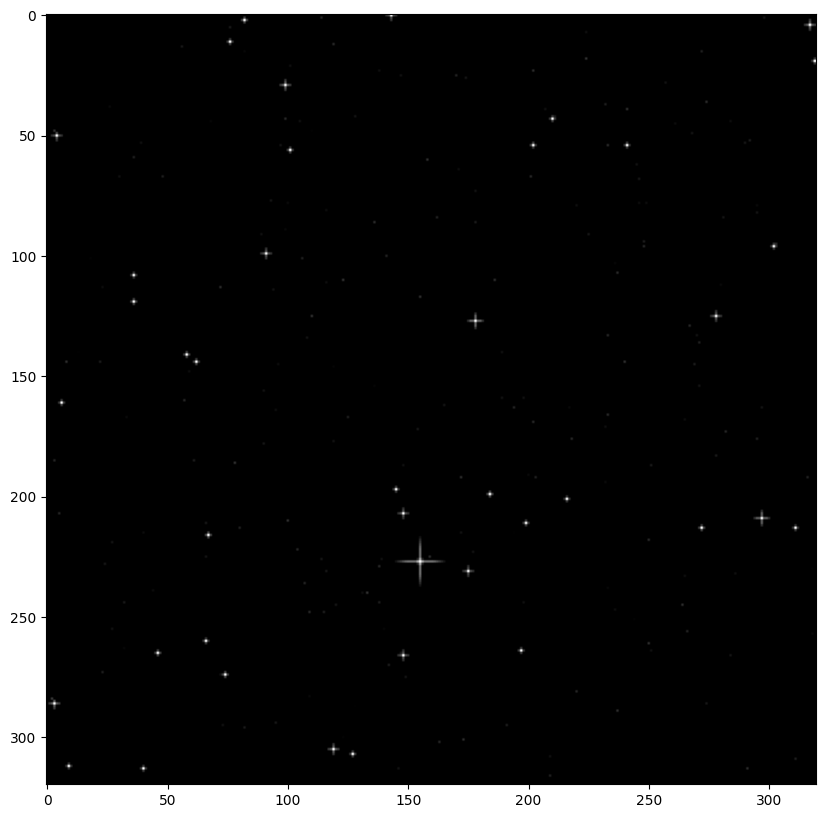

In [ ]:
image_size = (320, 320)
coords = (50, 50)
imageNoNoise = create_star_image(stars, planet_properties, coords, image_size, exposure_time, 0.75*minMagnitude, 4)

plt.figure(figsize=(10, 10))  # adjust the size as needed
plt.imshow(imageNoNoise, cmap='gray')
plt.show()

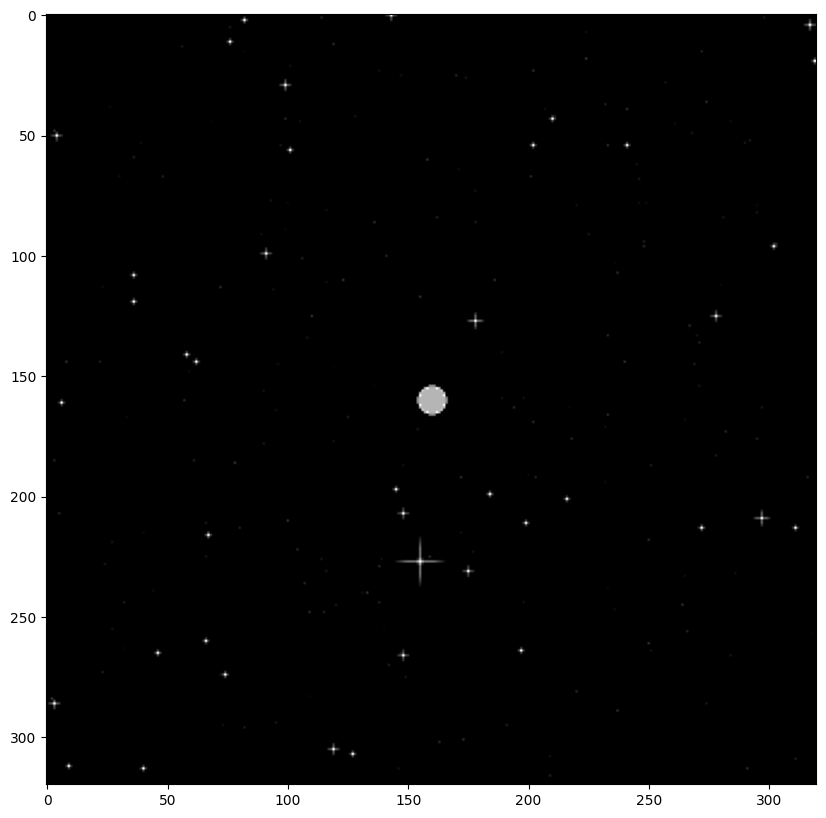

In [ ]:
image_with_object = add_object_to_image(
    imageNoNoise,
    planet_properties,
    coords,
    fov,
    exposure_time,
    aperture/1000
)

plt.figure(figsize=(10, 10))  # adjust the size as needed
plt.imshow(image_with_object, cmap='gray')
plt.show()

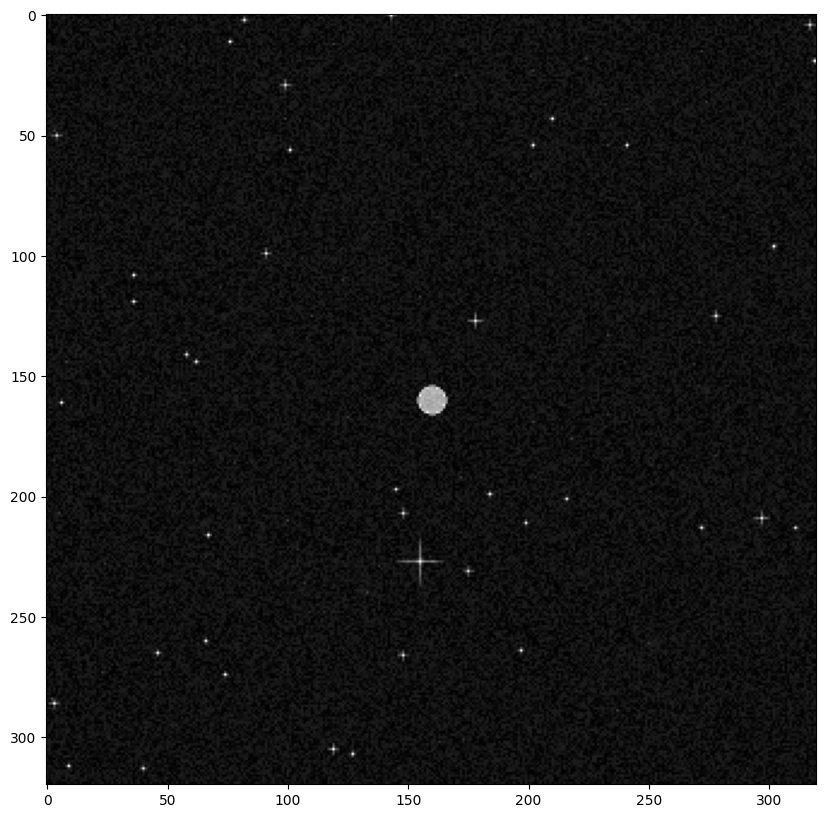

In [ ]:
imageNoise = combine_images_with_noise(image_with_object, 7)

plt.figure(figsize=(10, 10))  # adjust the size as needed
plt.imshow(imageNoise, cmap='gray')
plt.show()

##Saving images

In [ ]:
!rm -r starimg*
!mkdir starimg
!mv star_ima* starimg

In [ ]:
from google.colab import files
!zip -r /content/starimg.zip /content/starimg
files.download("/content/starimg.zip")

  adding: content/starimg/ (stored 0%)
  adding: content/starimg/star_image_4_of_6.png (deflated 7%)
  adding: content/starimg/star_image_5_of_6.png (deflated 7%)
  adding: content/starimg/star_image_2_of_6.png (deflated 7%)
  adding: content/starimg/star_image_3_of_6.png (deflated 6%)
  adding: content/starimg/star_image_1_of_6.png (deflated 6%)
  adding: content/starimg/star_image_6_of_6.png (deflated 7%)


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
!rm -r images*

In [ ]:
from google.colab import files
!zip -r /content/imagesForTraining.zip /content/imagesForTraining
files.download("/content/imagesForTraining.zip")

  adding: content/imagesForTraining/ (stored 0%)
  adding: content/imagesForTraining/interamnia_Alpha_290_2_of_2.png (deflated 6%)
  adding: content/imagesForTraining/euphrosyne_Delta_542_1_of_2.png (deflated 4%)
  adding: content/imagesForTraining/davida_Alpha_573_1_of_2.png (deflated 4%)
  adding: content/imagesForTraining/hektor_Beta_226_1_of_2.png (deflated 9%)
  adding: content/imagesForTraining/uranus_Alpha_357_2_of_2.png (deflated 5%)
  adding: content/imagesForTraining/hektor_Beta_226_2_of_2.png (deflated 9%)
  adding: content/imagesForTraining/davida_Alpha_573_2_of_2.png (deflated 4%)
  adding: content/imagesForTraining/jupiter_Gamma_242_2_of_2.png (deflated 7%)
  adding: content/imagesForTraining/uranus_Gamma_225_2_of_2.png (deflated 6%)
  adding: content/imagesForTraining/saturn_Delta_294_2_of_2.png (deflated 7%)
  adding: content/imagesForTraining/sylvia_Epsilon_382_1_of_2.png (deflated 4%)
  adding: content/imagesForTraining/sylvia_Epsilon_382_2_of_2.png (deflated 4%)
  ad

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>